<a href="https://colab.research.google.com/github/choltz95/density-estimation/blob/main/DS_manifold_with_boundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!pip install graphlearning jaxopt

In [73]:
#@title imports
import jax
from jax import numpy as jnp
from jax import jit, grad, vmap
from jax.experimental.sparse import BCOO
from jax.config import config; config.update("jax_enable_x64", True)

from jaxopt import GaussNewton, NonlinearCG

import numpy as np
import graphlearning as gl
import matplotlib.pyplot as plt

import scipy
from scipy import sparse, spatial

from tqdm.notebook import tqdm

<ipython-input-73-028808747185>:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config; config.update("jax_enable_x64", True)


In [74]:
def sinkhorn(K, maxiter=100, delta=1e-10, eps=1e-8):
    """https://epubs.siam.org/doi/pdf/10.1137/20M1342124 """
    D = np.array(np.sum(K,0)).squeeze()
    d0 = 1./(D + eps)
    dp = 1./(K@d0 + eps)
    d = 1./(K@dp + eps)
    tau = 2
    for tau in tqdm(range(maxiter)):
        d = 1. / (K.T@dp + eps)
        dr = np.sqrt(dp * d)
        if np.max(np.abs(dp / d - 1)) < delta:
          break
        dp = d
    K = scipy.sparse.diags(dr) @ K @ scipy.sparse.diags(dr)
    return K, d

In [130]:
N = 10000
m = 2
length = np.sqrt(np.random.uniform(0, 1, N))
angle = np.pi * np.random.uniform(0, 2, N)

sparse = False
noise_level=0.05

x = length * np.cos(angle)
y = length * np.sin(angle)

In [131]:
X = X_noiseless = np.stack([x,y],1)
X = np.stack([x,y, np.random.normal(loc=0,scale=noise_level,size=(N,))],1)

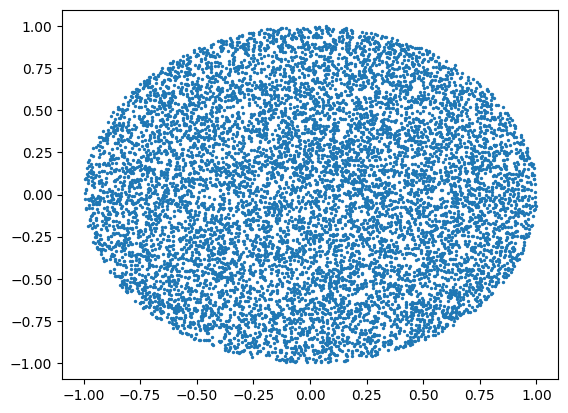

In [132]:
plt.scatter(X[:,0],X[:,1], s=2)
plt.show()

In [133]:
def __weights__(dists,h,m=2):
    """ Gaussian kernel: pi^{-m/2} exp(-||z||^2) """
    weights = (np.pi**(-m/2))*np.exp(-np.square(dists/h))
    fzero = 1
    return weights, fzero

def epsilon_ball(data, h, epsilon, epsilon_f=1, eta=None):
    """Construct a sparsified KDE (an epsilon-ball graph) """
    n = data.shape[0]  #Number of points

    #Rangesearch to find nearest neighbors
    Xtree = spatial.cKDTree(data)
    M = Xtree.query_pairs(epsilon)
    M = np.array(list(M))

    #Differences between points and neighbors
    V = data[M[:,0],:] - data[M[:,1],:]
    dists = np.sqrt(np.sum(V*V,axis=1))
    weights = __weights__(dists,h)

    # return K(||Xi - Xj|| / h)
    weights = np.concatenate((weights,weights))

    M1 = np.concatenate((M[:,0],M[:,1]))
    M2 = np.concatenate((M[:,1],M[:,0]))

    #Construct sparse matrix and convert to Compressed Sparse Row (CSR) format
    W = sparse.coo_matrix((weights, (M1,M2)),shape=(n,n))

    return W.tocsr()

In [134]:
"""Construct kernel kij =  exp (sqrt(||xi - xj||^2 / h^2)) """
from scipy.spatial.distance import pdist, squareform
h = 0.2
eps = 10.0 # just use all data for now

if sparse:
  K1 = epsilon_ball(X, h=h, epsilon=eps)
else:
  K1 = np.pi**(-m/2)*np.exp(-squareform(np.square(pdist(X)/h)))

In [146]:
K1 = sinkhorn(K1)[0]

  0%|          | 0/100 [00:00<?, ?it/s]

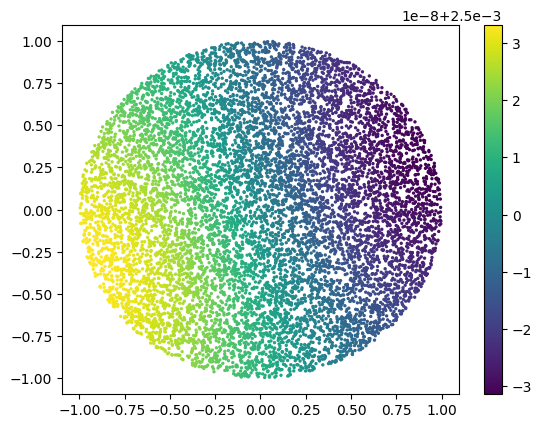

In [147]:
if sparse:
  fn = 1/(N*h**m)*np.array(K1.sum(1))
else:
  fn = 1/(N*h**m)*np.array(K1.sum(1,keepdims=True))
plt.scatter(X[:,0],X[:,1], s=2, c=fn)
plt.colorbar()
plt.show()

In [148]:
if sparse:
  K1bcoo = BCOO.from_scipy_sparse(K1)
  indices = K1bcoo.indices
  data = K1bcoo.data

In [149]:
"""Construct kernel kij =  K*(xi - xj)) """
@jit
def munval(ind, data, X):
  i,j = ind
  return data * (X[j] - X[i])

if sparse:
  K2 = vmap(munval, in_axes=(0, 0, None))(indices, data, jnp.array(X))
  K2 = BCOO((K2, indices), shape=K1bcoo.shape+(2,))
else:
  K2coef = X[:, None] - X[None, :]
  K2 = np.expand_dims(K1,-1)*K2coef


o = jnp.ones(N)
mun = o@K2
mun = 1/(N*h**(m+1))*mun
mun.shape

(10000, 3)

In [150]:
"""lower bound on bx """
c = fn / (jnp.sqrt(jnp.pi) * jnp.linalg.norm(mun,axis=1,keepdims=True))
lbbx = h * np.sqrt(np.maximum(0,np.log(c/2)))

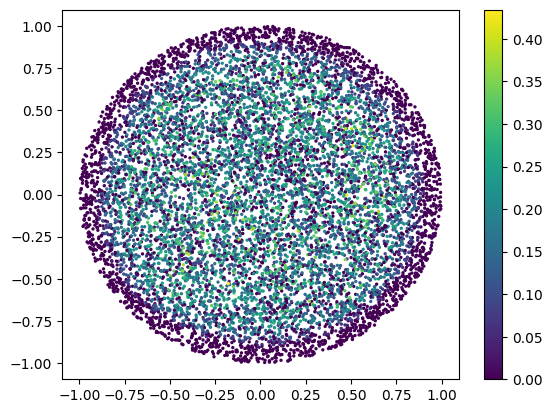

In [151]:
plt.scatter(X[:,0],X[:,1], s=2, c=lbbx)
plt.colorbar()
plt.show()

In [152]:
"""optimization of bx using gauss-newton on the residual """
@jit
def Fnormresid(bx, h, c):
  return jnp.linalg.norm((1 + jax.lax.erf(bx / h))*jnp.exp((bx*bx) / (h*h)) - c)

@jit
def F(bx, h, c):
  return (1 + jax.lax.erf(bx / h))*jnp.exp((bx*bx) / (h*h)) - c

x_init = lbbx
gn = GaussNewton(residual_fun=F, maxiter=1000, tol=1e-9, verbose=True)
gn_sol = gn.run(x_init, h=h, c=c).params

Solver: GaussNewton, Error: 6.345139106853921
Solver: GaussNewton, Error: 1.6092875601114933
Solver: GaussNewton, Error: 0.4996057803752946
Solver: GaussNewton, Error: 0.05534872384124168
Solver: GaussNewton, Error: 0.000846352533277958
Solver: GaussNewton, Error: 2.787746500446382e-07
Solver: GaussNewton, Error: 4.755942779150062e-12


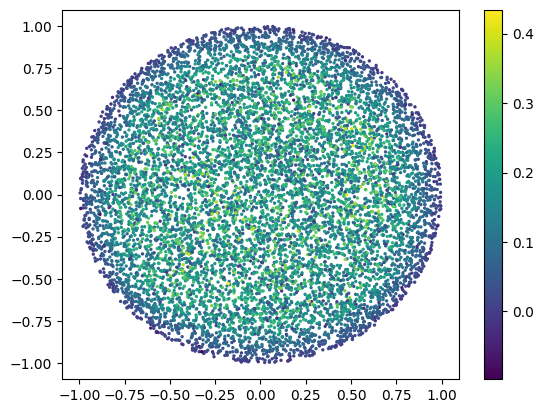

In [153]:
bx = gn_sol
m0 = jax.lax.erf(bx / h)

plt.scatter(X[:,0],X[:,1], s=2, c=bx)
plt.colorbar()
plt.show()

(-0.01, 1.01)

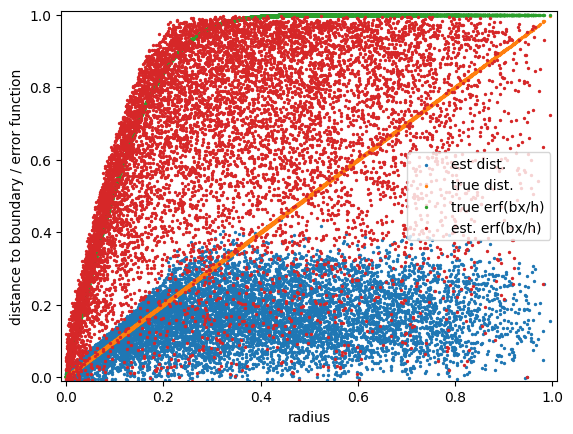

In [154]:
l = 1.0 - np.linalg.norm(X_noiseless, axis=1)
m0true = jax.lax.erf(l / h)

bx = gn_sol
m0 = jax.lax.erf((bx) / h)
lbbx = h * np.sqrt(np.maximum(0,np.log(c/2)))
#plt.scatter(l, lbbx, s=2, label='lower-bound dist.')
plt.scatter(l, bx, s=2, label='est dist.')
plt.scatter(l, l, s=2, label='true dist.')
plt.scatter(l, m0true, s=2, label='true erf(bx/h)')
plt.scatter(l, m0, s=2, label='est. erf(bx/h)')
plt.xlabel('radius')
plt.ylabel('distance to boundary / error function')
plt.legend()
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)

In [155]:
scipy.stats.pearsonr(l, bx.squeeze())
# normal kde noiselss: PearsonRResult(statistic=0.8653375623888311, pvalue=0.0)
# normal kde noisy: PearsonRResult(statistic=0.7219716341006133, pvalue=0.0)
# bistochastic noiseless: PearsonRResult(statistic=0.8039717447850383, pvalue=0.0)
# bistochastic noisy: PearsonRResult(statistic=0.6317592354427456, pvalue=0.0)

PearsonRResult(statistic=0.4396609789907673, pvalue=0.0)